In [1]:
# Импорт используемых библиотек в проекте
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
import time
import datetime
import pandas as pd
import numpy as np

## Проект: расчет стоимости закупки ИТ-комплектующих, оборудования и расходных материалов.

В данном проекте автоматизируем расчет стоимости закупки ИТ-комплетующих по требуемой спецификации.

Для расчета стоимости каждой позиции будем использовать источники ценовой информации (далее - ИЦИ) из открытых источников, отраслевой базе данных цен, предложений поставщиков.   
Выгрузка ценовой информации из Базы данных цен осущесвляется с помощью функционала SAP SRM.

Для удобства расчета необходимо подготовить следующие файлы в формате excel:
 * спецификацию с перечнем комплектующих и оборудования с указанием наименования, артикула, требуемого количества и единицы измерения;
 * файл "отчет о ценовых источниках", выгруженный по позициям из спецификации из базы данных с помощью функционаала SAP SRM;
 * ценовые предложения от поставщиков в формате excel.

1. Импортируем потребность в материалах из технического задания

In [2]:
path_equipment = 'C:/Users/alyap/Pet-project auto_nmp/Потребность.xlsx'

In [3]:
path_database = 'C:/Users/alyap/Pet-project auto_nmp/Отчет о ценовых источниках.xlsx'

In [4]:
equipment = pd.read_excel(path_equipment) # Загрузим спецификацию в датафрейм

Посмотрим на спецификацию расходных материалов

In [5]:
equipment

,Наименование,GID,Ед. Изм,Кол-во
0,"SSD Kingston A400 SA400S3 2.5"" 480Gb [SA400S37...",937220,шт.,25
1,"Жесткий диск HDD 3.5"" [WD10EZEX], 1ТБ",297949,шт.,18
2,Жесткий диск HDD Toshiba N300 NAS SATA3 8Tb 3....,2141375,шт.,28
3,Веб-камера Logitech HD Webcam C310 [960-001065],864868,шт.,112
4,Веб-камера Web-камера Logitech C930e [960-000972],816923,шт.,154
5,Модуль памяти AMD Radeon R7 Performance Series...,1086893,шт.,38
6,"ИБП APC Back-UPS 650 ВА 230 В, модель с розетк...",745489,шт.,150
7,Мышь Logitech B110 Silent [910-005508],1674255,шт.,930
8,Мышь для ноутбука беспроводная Logitech M185 D...,671947,шт.,425
9,"Клавиатура Logitech K280e, USB, [920-005215]",471665,шт.,765


Отметим, что артикул производителя расположен в квадратных скобках в столбце "Наименование"   
GID - код материала в отраслевой информационной системе. С помощью данного кода будем производить поиск цен позиций в ранее заключенных договорах.

Преобразуем датафрейм - артикул производителя переместим в отдельный столбец. По актикулу будем производить поиск цен в открытых источниках.

In [6]:
equipment['Артикул'] =  equipment['Наименование'].str.extract(r'\[(.*?)\]')

In [7]:
equipment['Артикул']

0              SA400S37/480G
1                   WD10EZEX
2               HDWG480UZSVA
3                 960-001065
4                 960-000972
5               R748G2133U2S
6               BC650-RSX761
7                 910-005508
8                 910-002238
9                 920-005215
10                920-009206
11                920-004518
12                910-004878
13                   8MB10AA
14             Logitech M100
15                920-003161
16                981-000475
17                 S500G3B0A
18          100-100000031BOX
19             i5-11400F OEM
20                    10EZRZ
21               ST600MP0006
22           NWD6602-EU0101F
23                   KN-2310
24                VCQP1000V2
25        NE63070019P2-1041A
26    GV-R68XTGAMING OC-16GD
Name: Артикул, dtype: object

Поместим все артикулы в список и далее будем производить поиск цен в интернете с помощью цикла из этого списка.

In [8]:
articul_list = equipment['Артикул'].tolist()

In [9]:
articul_list

['SA400S37/480G',
 'WD10EZEX',
 'HDWG480UZSVA',
 '960-001065',
 '960-000972',
 'R748G2133U2S',
 'BC650-RSX761',
 '910-005508',
 '910-002238',
 '920-005215',
 '920-009206',
 '920-004518',
 '910-004878',
 '8MB10AA',
 'Logitech M100',
 '920-003161',
 '981-000475',
 'S500G3B0A',
 '100-100000031BOX',
 'i5-11400F OEM',
 '10EZRZ',
 'ST600MP0006',
 'NWD6602-EU0101F',
 'KN-2310',
 'VCQP1000V2',
 'NE63070019P2-1041A',
 'GV-R68XTGAMING OC-16GD']

Цены из открытых источников (интернет-магазинов) будем собирать с помощью парсера на основе библиотеке selenium.

Цены на ИТ-оборудование и комплектующие будем брать с сайта-агрегатора n-katalog.ru.    
На данном сайте представлены актуальные цены крупных интернет-магазинов, таких как DNS, Ситилинк, Плеер.ру и т.д.   

Для решения данной задачи напишем две функции: 
1. Функция get_product_price осуществляет парсинг цен с сайта по заданному артикулу,
2. Функция get_open_prices возвращает датафрейм с найденными ценами по заданному списку артикулов.

## Функция парсинга цен из открытых источников с агрегатора n-katalog.ru

In [10]:
def get_product_price(articul):
    
    """
    Данная функция выполняет парсинг цен с сайта n-katalog.ru, имимтируя действия пользователя.
    Функция работает в случае предварительной инициализации webdriver - в нашем случае открытии браузера chrome.

    """
    
    # Путь к драйверу браузера
    DRIVER_PATH = 'C:/Users/alyap/anaconda3/Scripts/chromedriver-path.exe'

    # Инициализация WebDriver
    driver = webdriver.Chrome()
    try:
        search_url = f'https://n-katalog.ru/search?keyword={articul}'
        driver.get(search_url)
        time.sleep(1)  # Время ожидания загрузки страницы
        
        # Найти первую ссылку в результатах поиска и кликнуть по ней
        first_search_result_link = driver.find_element(By.CSS_SELECTOR, '[data-idgood]')
        first_search_result_link.click()
        
        time.sleep(1)  # Время ожидания загрузки страницы товара
        try:
            # Поиск блока с ценами и наименованием магазинов
            shops_elements = driver.find_elements(By.CLASS_NAME, 'desc-hot-prices')

            #Поиск наименования товара:
            title_element = driver.find_elements(By.CLASS_NAME, 'title-for-page')


            # Создание списков: артикулов, магазинов, цен
            prices_dict = {}
            shop_list = []
            prices_list = []
            articul_list = []
            title_list = []

            # Перебор элементов из блоков с наименованием магазинов и цен и запись данных в списки
            for shop_element in shops_elements:
                shop_name_elements = shop_element.find_elements(By.CLASS_NAME, 'model-shop-name')
                shop_price_elements = shop_element.find_elements(By.CLASS_NAME, 'model-shop-price')
                for shop, price in zip(shop_name_elements, shop_price_elements):
                    shop_name = shop.text
                    shop_price = price.text

                    shop_list.append(shop_name)
                    prices_list.append(shop_price)
                    articul_list.append(articul)
                    title_list.append(title_element[0].text)

            # Создание итогового словаря с собранными данными
            prices_dict = {'Наименование':title_list, 'Артикул':articul_list, 'ИЦИ':shop_list, 'Цена':prices_list}

            return prices_dict
        except Exception as t:
            return None
    except Exception as e:
        return None


## Функция преобразования найденных открытых источников по заданному списку артикулов в датафрейм.

In [11]:
def get_open_prices(articul_list):
    
    # Создадим пустой датафрейм для добавления ценовых источников
    open_prices = pd.DataFrame()

    # Для каждого артикула из списка найдем цены с сайта n-katalog.ru и запишем все данные в датафрейм
    for articul in articul_list:
        dict_i = get_product_price(articul)
        if dict_i is not None:
            df_i = pd.DataFrame(dict(dict_i))
            open_prices = pd.concat([open_prices,df_i])
    return open_prices

Создадим датафрейм с ценами из открытых источников

In [12]:
open_prices = get_open_prices(articul_list)

По данному количеству артикулов найдены цены

In [13]:
open_prices['Артикул'].nunique()

17

In [14]:
open_prices.head(10)

,Наименование,Артикул,ИЦИ,Цена
0,SSD Kingston A400 SA400S37/480G SA400S37\/480G,SA400S37/480G,Плеер.Ру →,3324 руб.
1,SSD Kingston A400 SA400S37/480G SA400S37\/480G,SA400S37/480G,ОЛДИ →,4140 руб.
2,SSD Kingston A400 SA400S37/480G SA400S37\/480G,SA400S37/480G,xcom-shop.ru →,3989 руб.
3,SSD Kingston A400 SA400S37/480G SA400S37\/480G,SA400S37/480G,CompDay →,3140 руб.
0,Жесткий диск WD Blue WD10EZEX 10EZEX,WD10EZEX,DNS →,5699 руб.
1,Жесткий диск WD Blue WD10EZEX 10EZEX,WD10EZEX,СП-Компьютер,6300 руб.
2,Жесткий диск WD Blue WD10EZEX 10EZEX,WD10EZEX,CompDay →,5560 руб.
3,Жесткий диск WD Blue WD10EZEX 10EZEX,WD10EZEX,Сима-ленд →,8860 руб.
0,Жесткий диск Toshiba N300 HDWG480UZSVA HDWG480...,HDWG480UZSVA,Ситилинк →,24990 руб.
0,"WEB-камера Logitech HD Webcam C310 960-000638,...",960-001065,Сима-ленд →,4441 руб.


Наименование интернет-магазина взято с сайта с дополнительным символом. Избавимся от него.

In [15]:
open_prices['ИЦИ'] = open_prices['ИЦИ'].str.replace(' →','')

In [16]:
open_prices.head()

,Наименование,Артикул,ИЦИ,Цена
0,SSD Kingston A400 SA400S37/480G SA400S37\/480G,SA400S37/480G,Плеер.Ру,3324 руб.
1,SSD Kingston A400 SA400S37/480G SA400S37\/480G,SA400S37/480G,ОЛДИ,4140 руб.
2,SSD Kingston A400 SA400S37/480G SA400S37\/480G,SA400S37/480G,xcom-shop.ru,3989 руб.
3,SSD Kingston A400 SA400S37/480G SA400S37\/480G,SA400S37/480G,CompDay,3140 руб.
0,Жесткий диск WD Blue WD10EZEX 10EZEX,WD10EZEX,DNS,5699 руб.


Цена указана в строковом формате с указанием валюты. Преобразуем данную переменную, валюту вынесем в отдельную колонку.

Убедимся, что указана только одна валюта - рубли

In [17]:
open_prices['Цена'].str[-4:].value_counts()

руб.    54
Name: Цена, dtype: int64

In [18]:
open_prices['Валюта'] = open_prices['Цена'].str[-4:]

In [19]:
open_prices['Цена'] = open_prices['Цена'].str.replace(' руб.','').astype(float)

C:\Users\alyap\AppData\Local\Temp\ipykernel_2532\276544439.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  open_prices['Цена'] = open_prices['Цена'].str.replace(' руб.','').astype(float)


In [20]:
open_prices.dtypes

Наименование     object
Артикул          object
ИЦИ              object
Цена            float64
Валюта           object
dtype: object

In [21]:
open_prices.head()

,Наименование,Артикул,ИЦИ,Цена,Валюта
0,SSD Kingston A400 SA400S37/480G SA400S37\/480G,SA400S37/480G,Плеер.Ру,3324.0,руб.
1,SSD Kingston A400 SA400S37/480G SA400S37\/480G,SA400S37/480G,ОЛДИ,4140.0,руб.
2,SSD Kingston A400 SA400S37/480G SA400S37\/480G,SA400S37/480G,xcom-shop.ru,3989.0,руб.
3,SSD Kingston A400 SA400S37/480G SA400S37\/480G,SA400S37/480G,CompDay,3140.0,руб.
0,Жесткий диск WD Blue WD10EZEX 10EZEX,WD10EZEX,DNS,5699.0,руб.


Загрузим отчет о ценовых источниках с информацией о ранее заключенных сделках за последние 2 года по нашей спецификации.

In [22]:
data = pd.read_excel('C:/Users/alyap/Pet-project auto_nmp/Отчет о ценовых источниках.xlsx')

In [23]:
data.head()

,№ позиции,GID,Система источник МТРиО,Ид. \nМТРиО,Наименование МТРиО,Тип источника,Тип позиции,Дата документа,Цена без НДС за 1 ЕИ в руб,ЕИ
0,1,937220,ЕОС-Закупки,1709702,НАКОПИТЕЛЬ SSD SA400S37/480G KINGSTON,Договор,Эталон,2023-08-24,2055.00,ШТ
1,1,937220,ЕОС-Закупки,1709702,НАКОПИТЕЛЬ SSD SA400S37/480G KINGSTON,Договор,Эталон,2023-06-30,2509.00,ШТ
2,1,937220,ЕОС-Закупки,1709702,НАКОПИТЕЛЬ SSD SA400S37/480G KINGSTON,Договор,Эталон,2023-06-23,1977.00,ШТ
3,1,937220,ЕОС-Закупки,1709702,НАКОПИТЕЛЬ SSD SA400S37/480G KINGSTON,Договор,Эталон,2023-04-19,2358.33,ШТ
4,1,937220,ЕОС-Закупки,1709702,НАКОПИТЕЛЬ SSD SA400S37/480G KINGSTON,Предложение поставщика,Эталон,2023-03-31,2292.00,ШТ


В данном отчете нас интересует информация: код GID, наименование,тип источника, дата документа, цена за ед., единица измерения

In [24]:
data.drop(columns=['№ позиции', 'Ид. \nМТРиО', 'Тип позиции'], inplace=True)

In [25]:
data.dtypes

GID                                    int64
Система источник МТРиО                object
Наименование МТРиО                    object
Тип источника                         object
Дата документа                datetime64[ns]
Цена без НДС за 1 ЕИ в руб           float64
ЕИ                                    object
dtype: object

Дата подгрузилась в нужном формате. Преобразуем дату и оставим год и месяц

In [26]:
data['Месяц'] = data['Дата документа'].dt.to_period('M')

In [27]:
data.rename(columns={'Цена без НДС за 1 ЕИ в руб':'Цена'}, inplace=True) # Переименуем колонку с ценой

Подгрузим данные с сайта статистики - индексы цен производителей к предыдущему месяцу за последние 3 года

Каждый год в файле располагается на отдельном листе. Подгрузим сначала данные за 2021 год.

In [28]:
stats_2021 = pd.read_excel('C:/Users/alyap/Pet-project auto_nmp/ИЦП ВЭД сентябрь 2023.xlsx', \
                           sheet_name='10', header=3) # датафрейм за 2021 год

In [29]:
stats_2021.head()

,Unnamed: 0,ОКВЭД2,январь,февраль,март,апрель,май,июнь,июль,август,сентябрь,октябрь,ноябрь,декабрь
0,Лесоводство и лесозаготовки,2,101.50,102.11,102.01,102.06,101.38,102.72,103.52,104.60,103.61,102.99,100.06,99.41
1,Лесозаготовки,2.2,101.67,101.65,102.11,102.33,102.23,102.57,103.87,105.50,103.74,103.25,99.92,99.19
2,Предоставление услуг в области лесоводства и л...,2.4,100.13,105.91,101.16,99.88,94.31,104.08,100.41,96.35,102.30,100.31,101.57,101.65
3,Рыболовство и рыбоводство,3,108.49,102.42,99.59,102.06,98.36,99.06,100.21,100.01,103.47,103.75,103.75,104.39
4,Рыболовство,3.1,109.09,102.58,99.44,102.16,97.97,98.63,99.99,99.98,103.43,103.79,104.05,104.91


In [30]:
stats_2021.rename(columns = {'Unnamed: 0':'Категория'}, inplace=True)

К колонкам добавим год

In [31]:
stats_2021.columns.values[2:] = [col + '_2021' for col in stats_2021.columns.values[2:]]

In [32]:
stats_2021.drop(columns='ОКВЭД2', inplace=True) # удалим ненужный столбец с ОКВЭД

Выберем нужную нам группу товара

In [33]:
stats_2021 = stats_2021.query("Категория == 'Производство компьютеров и периферийного оборудования'")
stats_2021

,Категория,январь_2021,февраль_2021,март_2021,апрель_2021,май_2021,июнь_2021,июль_2021,август_2021,сентябрь_2021,октябрь_2021,ноябрь_2021,декабрь_2021
173,Производство компьютеров и периферийного обору...,98.86,100.9,102.44,96.68,105.9,100.28,104.38,96.15,108.19,102.15,94.01,97.27


Получили итоговую строку с нужными индексами.   
Теперь нужно сделать то же для 2022 и 2023 года.   
Выведем итоговый датафрейм

In [34]:
path = 'C:/Users/alyap/Pet-project auto_nmp/ИЦП ВЭД сентябрь 2023.xlsx' # Путь к файлу

In [35]:
list_sheets = ['10', '14', '18'] # Номера листов в файле excel для 2021, 2022 и 2023 года соответственно
df = pd.DataFrame()
for i in list_sheets:
    if i != '18':
        df_i = pd.read_excel(path, sheet_name=i, header=3) # Чтение файла
        if i == '10':
            df_i.columns.values[2:] = [col + '_2021' for col in df_i.columns.values[2:]] # Добавляем год к месяцу
        if i == '14':
            df_i.columns.values[2:] = [col + '_2022' for col in df_i.columns.values[2:]]
    else:
        df_i = pd.read_excel(path, sheet_name=i, header=2)
        df_i.columns.values[2:] = [col + '_2023' for col in df_i.columns.values[2:]]
    df_i.rename(columns = {'Unnamed: 0':'Категория'}, inplace=True)
    df_i = df_i.query("Категория == 'Производство компьютеров и периферийного оборудования'") # Фильтруем по категории
    df_i.drop(columns = df_i.columns.values[:2], inplace=True) # Удаляем лишние колонки
    df_i = df_i.stack().reset_index() # Колонки трансформируем в строки
    df_i.drop(columns='level_0', inplace=True)
    df_i.columns = ['Дата', 'Индекс']
    df = pd.concat([df, df_i]) # Соединяем датафреймы
# Часть дат копируется из файла со сносками. Удалим лишние элементы из текста
braces = {'(', ')'}
df['Дата'] = df['Дата'].apply(lambda x:''.join(ch for ch in x if ch not in braces))
df['Дата'] = df['Дата'].str.replace('1_', '_')
# Преобразуем индекс в числовой формат
df['Индекс'] = df['Индекс'].astype(float)

In [36]:
df.tail()

,Дата,Индекс
4,май_2023,107.33
5,июнь_2023,106.77
6,июль_2023,100.08
7,август_2023,95.56
8,сентябрь_2023,103.89


Преобразуем дату из строки в нужный нам формат "месяц-год".   
Для этого создадим функцию преобразования.

In [37]:
def convert_date_format(df):
    # Преобразование месяца в числовой формат
    month_dict = {
        'январь': 1, 'февраль': 2, 'март': 3, 'апрель': 4, 'май': 5, 'июнь': 6,
        'июль': 7, 'август': 8, 'сентябрь': 9, 'октябрь': 10, 'ноябрь': 11, 'декабрь': 12
    }
    # Разделение строки на месяц и год
    df['месяц'], df['год'] = df['Дата'].str.split('_').str
    # Преобразование месяца в числовой формат
    df['месяц'] = df['месяц'].map(month_dict)
    # Преобразование в формат месяц-год
    df['Месяц'] = pd.to_datetime(df['год'].astype(str) + '-' + df['месяц'].astype(str) + '-01', format='%Y-%m-%d')
    df['Месяц'] = df['Месяц'].dt.to_period('M')
    # Удаление временных столбцов
    df.drop(columns=['месяц', 'год', 'Дата'], inplace=True)
    return df

In [38]:
convert_date_format(df)

C:\Users\alyap\AppData\Local\Temp\ipykernel_2532\113211020.py:8: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df['месяц'], df['год'] = df['Дата'].str.split('_').str


,Индекс,Месяц
0,98.86,2021-01
1,100.90,2021-02
2,102.44,2021-03
3,96.68,2021-04
4,105.90,2021-05
5,100.28,2021-06
6,104.38,2021-07
7,96.15,2021-08
8,108.19,2021-09
9,102.15,2021-10


Рассчитаем коэффициенты - делим индексы на 100 и заменим столбец индекс рассчитанными значениями

In [39]:
df['Индекс'] = round(df['Индекс'] / 100,4)

In [40]:
df.head()

,Индекс,Месяц
0,0.9886,2021-01
1,1.0090,2021-02
2,1.0244,2021-03
3,0.9668,2021-04
4,1.0590,2021-05


Для расчета коэффициента приведения к текущей рыночной цене необходимо перемножить полученные коэффициенты с рассматриваемого месяца и года до последнего месяца.   

In [41]:
df.set_index('Месяц', inplace=True)

In [42]:
df['Коэффициент_приведения'] = [round(df.loc[x:]['Индекс'].prod(),4) for x in df.index]
    

In [43]:
df.reset_index(inplace=True)

In [44]:
df.head()

,Месяц,Индекс,Коэффициент_приведения
0,2021-01,0.9886,0.9422
1,2021-02,1.0090,0.9531
2,2021-03,1.0244,0.9446
3,2021-04,0.9668,0.9221
4,2021-05,1.0590,0.9538


Добавим статистические данные в датафрейм отчета о ценовых источниках

In [45]:
data = data.merge(df[['Месяц', 'Коэффициент_приведения']], on='Месяц')
data.head()

,GID,Система источник МТРиО,Наименование МТРиО,Тип источника,Дата документа,Цена,ЕИ,Месяц,Коэффициент_приведения
0,937220,ЕОС-Закупки,НАКОПИТЕЛЬ SSD SA400S37/480G KINGSTON,Договор,2023-08-24,2055.0,ШТ,2023-08,0.9928
1,297949,ЕОС-Закупки,ДИСК ЖЕСТКИЙ ВНУТРЕННИЙ WD10EZEX 1000GB 7200ОБ...,Предложение поставщика,2023-08-19,3705.0,ШТ,2023-08,0.9928
2,937220,ЕОС-Закупки,НАКОПИТЕЛЬ SSD SA400S37/480G KINGSTON,Договор,2023-06-30,2509.0,ШТ,2023-06,1.0608
3,937220,ЕОС-Закупки,НАКОПИТЕЛЬ SSD SA400S37/480G KINGSTON,Договор,2023-06-23,1977.0,ШТ,2023-06,1.0608
4,297949,ЕОС-Закупки,ДИСК ЖЕСТКИЙ ВНУТРЕННИЙ WD10EZEX 1000GB 7200ОБ...,Договор,2023-06-22,4405.0,ШТ,2023-06,1.0608


Переименуем колонку с ценой и рассчитаем приведенную цену до текущего уровня с помощью рассчитанных коэффициентов

In [46]:
data = data.rename(columns={'Цена':'Цена_источника'})

In [47]:
data['Цена'] = round(data['Цена_источника'] * data['Коэффициент_приведения'],2)

Отсортируем датафрейм по убыванию в рамках каждого товара

In [48]:
data.sort_values(['GID', 'Дата документа'], ascending=False, inplace=True)

In [49]:
data['Row_Number'] = data.groupby('GID').cumcount() + 1

In [50]:
data.head(20)

,GID,Система источник МТРиО,Наименование МТРиО,Тип источника,Дата документа,Цена_источника,ЕИ,Месяц,Коэффициент_приведения,Цена,Row_Number
27,2393876,ЕОС-Закупки,НАКОПИТЕЛЬ WD BLUE WDS500G3B0A SSD 500ГБ SATA ...,Договор,2023-03-29,2934.00,ШТ,2023-03,0.8795,2580.45,1
101,2393876,ЕОС-Закупки,НАКОПИТЕЛЬ WD BLUE WDS500G3B0A SSD 500ГБ SATA ...,Договор,2022-12-13,3405.00,ШТ,2022-12,0.8621,2935.45,2
131,1978652,ЕОС-Закупки,ВИДЕОКАРТА VCQP1000V2-PB NVIDIA QUADRO P1000 PNY,Предложение поставщика,2022-01-31,32899.73,ШТ,2022-01,0.8855,29132.71,1
132,1978652,ЕОС-Закупки,ВИДЕОКАРТА VCQP1000V2-PB NVIDIA QUADRO P1000 PNY,Предложение поставщика,2022-01-30,32899.73,ШТ,2022-01,0.8855,29132.71,2
133,1978652,ЕОС-Закупки,ВИДЕОКАРТА VCQP1000V2-PB NVIDIA QUADRO P1000 PNY,Предложение поставщика,2022-01-30,32899.73,ШТ,2022-01,0.8855,29132.71,3
134,1978652,ЕОС-Закупки,ВИДЕОКАРТА VCQP1000V2-PB NVIDIA QUADRO P1000 PNY,Предложение поставщика,2022-01-28,32899.73,ШТ,2022-01,0.8855,29132.71,4
70,1939258,ЕОС-Закупки,ПРОЦЕССОР CORE I5-11400F BX8070811400F INTEL,Договор,2023-07-17,14635.00,ШТ,2023-07,0.9936,14541.34,1
73,1674255,ЕОС-Закупки,МЫШЬ B110 SILENT 910-005508 ОПТИЧЕСКАЯ ЛАЗЕРНА...,Договор,2023-05-19,566.50,ШТ,2023-05,1.1386,645.02,1
107,1674255,ЕОС-Закупки,МЫШЬ B110 SILENT 910-005508 ОПТИЧЕСКАЯ ЛАЗЕРНА...,Договор,2022-11-08,394.00,ШТ,2022-11,0.9185,361.89,2
36,1674255,ЕОС-Закупки,МЫШЬ B110 SILENT 910-005508 ОПТИЧЕСКАЯ ЛАЗЕРНА...,Предложение поставщика,2022-10-04,189.00,ШТ,2022-10,0.9268,175.17,3


In [51]:
data['Цена'] = round(data['Цена_источника'] * 1.2, 2) # Рассчитаем итоговую цену с НДС 20%

Для массива цен достаточно трех источников из исторических данных. Отсечем лишние данные.

In [52]:
data_ = data.query('Row_Number <= 3')

In [53]:
data_ = data_.rename(columns = {'Тип источника':'ИЦИ'})

In [54]:
data_.head()

,GID,Система источник МТРиО,Наименование МТРиО,ИЦИ,Дата документа,Цена_источника,ЕИ,Месяц,Коэффициент_приведения,Цена,Row_Number
27,2393876,ЕОС-Закупки,НАКОПИТЕЛЬ WD BLUE WDS500G3B0A SSD 500ГБ SATA ...,Договор,2023-03-29,2934.00,ШТ,2023-03,0.8795,3520.80,1
101,2393876,ЕОС-Закупки,НАКОПИТЕЛЬ WD BLUE WDS500G3B0A SSD 500ГБ SATA ...,Договор,2022-12-13,3405.00,ШТ,2022-12,0.8621,4086.00,2
131,1978652,ЕОС-Закупки,ВИДЕОКАРТА VCQP1000V2-PB NVIDIA QUADRO P1000 PNY,Предложение поставщика,2022-01-31,32899.73,ШТ,2022-01,0.8855,39479.68,1
132,1978652,ЕОС-Закупки,ВИДЕОКАРТА VCQP1000V2-PB NVIDIA QUADRO P1000 PNY,Предложение поставщика,2022-01-30,32899.73,ШТ,2022-01,0.8855,39479.68,2
133,1978652,ЕОС-Закупки,ВИДЕОКАРТА VCQP1000V2-PB NVIDIA QUADRO P1000 PNY,Предложение поставщика,2022-01-30,32899.73,ШТ,2022-01,0.8855,39479.68,3


Соединим все ценовые источники в один датафрейм.

In [55]:
equipment_df = equipment.merge(open_prices[['Артикул', 'ИЦИ', 'Цена']], on = 'Артикул')
equipment_df.head()

,Наименование,GID,Ед. Изм,Кол-во,Артикул,ИЦИ,Цена
0,"SSD Kingston A400 SA400S3 2.5"" 480Gb [SA400S37...",937220,шт.,25,SA400S37/480G,Плеер.Ру,3324.0
1,"SSD Kingston A400 SA400S3 2.5"" 480Gb [SA400S37...",937220,шт.,25,SA400S37/480G,ОЛДИ,4140.0
2,"SSD Kingston A400 SA400S3 2.5"" 480Gb [SA400S37...",937220,шт.,25,SA400S37/480G,xcom-shop.ru,3989.0
3,"SSD Kingston A400 SA400S3 2.5"" 480Gb [SA400S37...",937220,шт.,25,SA400S37/480G,CompDay,3140.0
4,"Жесткий диск HDD 3.5"" [WD10EZEX], 1ТБ",297949,шт.,18,WD10EZEX,DNS,5699.0


In [56]:
data_2 = equipment.merge(data_[['GID', 'ИЦИ', 'Цена']], on = 'GID', how = 'inner')
data_2.head()

,Наименование,GID,Ед. Изм,Кол-во,Артикул,ИЦИ,Цена
0,"SSD Kingston A400 SA400S3 2.5"" 480Gb [SA400S37...",937220,шт.,25,SA400S37/480G,Договор,2466.0
1,"SSD Kingston A400 SA400S3 2.5"" 480Gb [SA400S37...",937220,шт.,25,SA400S37/480G,Договор,3010.8
2,"SSD Kingston A400 SA400S3 2.5"" 480Gb [SA400S37...",937220,шт.,25,SA400S37/480G,Договор,2372.4
3,"Жесткий диск HDD 3.5"" [WD10EZEX], 1ТБ",297949,шт.,18,WD10EZEX,Договор,4206.0
4,"Жесткий диск HDD 3.5"" [WD10EZEX], 1ТБ",297949,шт.,18,WD10EZEX,Предложение поставщика,4446.0


Соединим два датафрейма

In [57]:
equipment_df = pd.concat([equipment_df, data_2])

Импортируем библиотеки для визуализации

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


In [59]:
# Настройка отображения графиков

sns.set(
    font_scale=2,
    style="darkgrid",
    rc={'figure.figsize':(40,60)}
        )

<AxesSubplot:xlabel='Цена', ylabel='Наименование'>

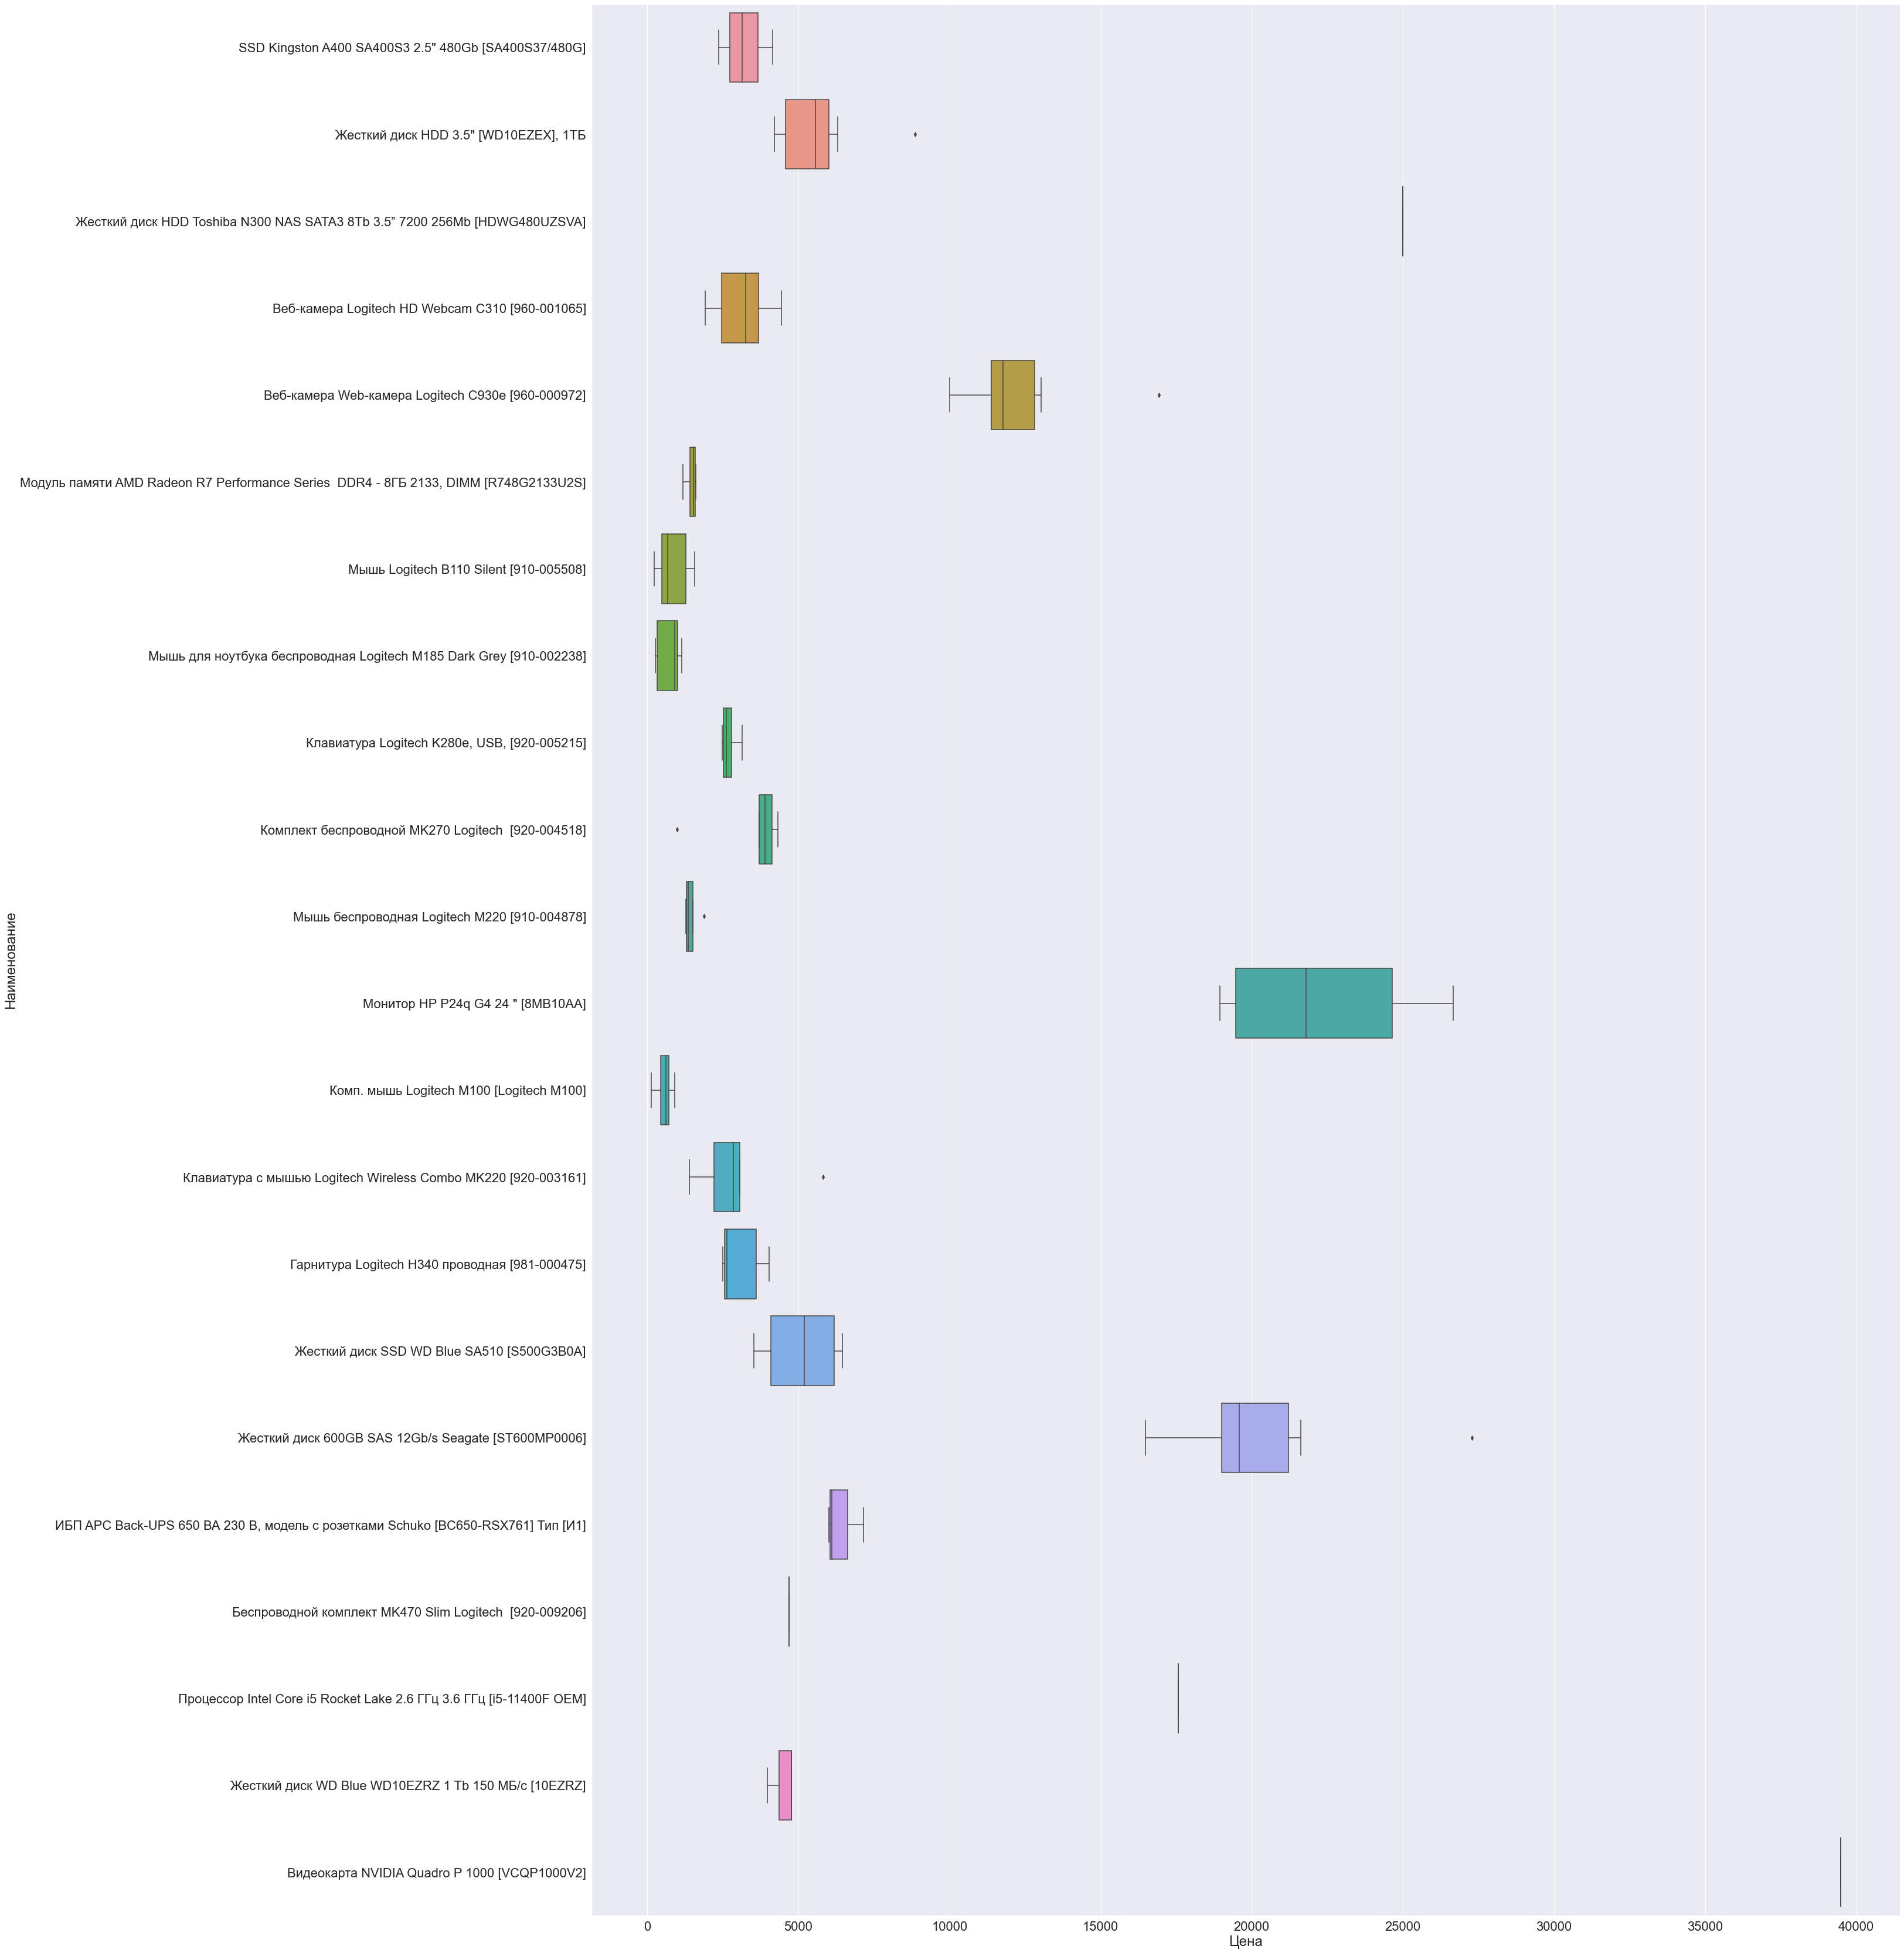

In [60]:
sns.boxplot(y = equipment_df['Наименование'], x = equipment_df['Цена'])

Из графика заметим, что по некоторым позициям достаточно большой разброс цен.   
Присутствуют как и очень малые значения (в случае ранее заключенных договоров и применения заниженных индексов Росстат), так и достаточно высокие цены.

В качестве единичных расценок рекомендую применять медианные цены из массива. Данное решение наиболее отражает рыночную стоимость продукции и не завышает ее.

Рассчитаем для каждой позиции минимальную, медианную и среднюю цену, а также количество источников

In [61]:
purchase_prices = equipment_df.groupby(['Наименование', 'GID'], as_index=False)['Цена']\
                                .agg(['mean', 'median', 'min', 'count'])\
                                .reset_index()

In [62]:
purchase_prices

,Наименование,GID,mean,median,min,count
0,"SSD Kingston A400 SA400S3 2.5"" 480Gb [SA400S37...",937220,3206.028571,3140.000,2372.40,7
1,Беспроводной комплект MK470 Slim Logitech [92...,1543586,4686.000000,4686.000,4686.00,1
2,Веб-камера Logitech HD Webcam C310 [960-001065],864868,3128.811429,3264.000,1911.29,7
3,Веб-камера Web-камера Logitech C930e [960-000972],816923,12477.845000,11767.535,9999.00,6
4,Видеокарта NVIDIA Quadro P 1000 [VCQP1000V2],1978652,39479.680000,39479.680,39479.68,3
5,Гарнитура Logitech H340 проводная [981-000475],635472,3067.200000,2640.000,2490.00,7
6,Жесткий диск 600GB SAS 12Gb/s Seagate [ST600MP...,1628652,20582.931667,19578.000,16479.00,6
7,"Жесткий диск HDD 3.5"" [WD10EZEX], 1ТБ",297949,5679.571429,5560.000,4206.00,7
8,Жесткий диск HDD Toshiba N300 NAS SATA3 8Tb 3....,2141375,24990.000000,24990.000,24990.00,1
9,Жесткий диск SSD WD Blue SA510 [S500G3B0A],2393876,5087.360000,5190.000,3520.80,5


In [63]:
purchase_prices['НМЦ_ед'] = round(purchase_prices['median'],2)

Рассчитаем общую стоимость закупки

In [64]:
purchase_prices_ = equipment.merge(purchase_prices[['GID', 'НМЦ_ед']], on = 'GID', how = 'inner')

In [65]:
purchase_prices_['Сумма'] = round(purchase_prices_['Кол-во'] * purchase_prices_['НМЦ_ед'], 2)

Итоговая спецификация закупки:

In [66]:
purchase_prices_

,Наименование,GID,Ед. Изм,Кол-во,Артикул,НМЦ_ед,Сумма
0,"SSD Kingston A400 SA400S3 2.5"" 480Gb [SA400S37...",937220,шт.,25,SA400S37/480G,3140.00,78500.00
1,"Жесткий диск HDD 3.5"" [WD10EZEX], 1ТБ",297949,шт.,18,WD10EZEX,5560.00,100080.00
2,Жесткий диск HDD Toshiba N300 NAS SATA3 8Tb 3....,2141375,шт.,28,HDWG480UZSVA,24990.00,699720.00
3,Веб-камера Logitech HD Webcam C310 [960-001065],864868,шт.,112,960-001065,3264.00,365568.00
4,Веб-камера Web-камера Logitech C930e [960-000972],816923,шт.,154,960-000972,11767.54,1812201.16
5,Модуль памяти AMD Radeon R7 Performance Series...,1086893,шт.,38,R748G2133U2S,1535.50,58349.00
6,"ИБП APC Back-UPS 650 ВА 230 В, модель с розетк...",745489,шт.,150,BC650-RSX761,6106.24,915936.00
7,Мышь Logitech B110 Silent [910-005508],1674255,шт.,930,910-005508,679.80,632214.00
8,Мышь для ноутбука беспроводная Logitech M185 D...,671947,шт.,425,910-002238,903.60,384030.00
9,"Клавиатура Logitech K280e, USB, [920-005215]",471665,шт.,765,920-005215,2608.50,1995502.50


Coхраним в excel файл

In [67]:
purchase_prices_.to_excel('Спецификация_закупки.xlsx')